In [11]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [12]:
from keras import backend as K

In [13]:
import os

In [14]:
!pip install PyMaxflow
import maxflow

In [15]:
# Load the grayscale images
img_left = cv.imread('/kaggle/input/section-1-disparity-map/scene_L.ppm', 0)
img_right = cv.imread('/kaggle/input/section-1-disparity-map/scene_R.ppm', 0)

In [63]:
def calculate_unary_cost(gradient_left,gradient_right,magnitude_left,magnitude_right):
    # Calculate the unary costs
    unary_cost = np.zeros_like(img_left, dtype=np.float32)
    for i in range(img_left.shape[0]):
        for j in range(img_left.shape[1]):
            unary_cost[i, j] = np.abs(img_left[i, j] - img_right[i, j]) + np.abs(magnitude_left[i, j] - magnitude_right[i, j])
    return unary_cost
    
def calculate_pair_wise_cost(lambda_, beta):
    pairwise_cost = np.zeros((256, 256), dtype=np.float32)
    for i in range(256):
        for j in range(256):
            pairwise_cost[i, j] = lambda_ * np.exp(-np.square(i - j) / (2 * beta * beta))
    return pairwise_cost

def is_safe(x, y, img_left):
    return x >= 0 and x < img_left.shape[0] and y >= 0 and y < img_left.shape[1]

def calculate_disparity_map(unary_cost, pairwise_cost):
    # Create the graph
    g = maxflow.Graph[int](0, 0)
    nodeids = g.add_grid_nodes(img_left.shape)

    # Add the unary costs to the graph
    g.add_grid_tedges(nodeids, unary_cost, 255 - unary_cost)

    # Add the pairwise costs to the graph
    neighborhood = ((1, 0), (-1, 0))
    for i in range(img_left.shape[0]):
        for j in range(img_left.shape[1]):
            for dx, dy in neighborhood:
                x = i + dx
                y = j + dy
                if is_safe(x, y, img_left):
                    g.add_edge(nodeids[i, j], nodeids[x, y], pairwise_cost[int(img_left[i, j]), int(img_left[x, y])],
                               pairwise_cost[int(img_left[x, y]), int(img_left[i, j])])

    # Apply the graph cut algorithm
    g.maxflow()
    correspondence_map = g.get_grid_segments(nodeids)
    return correspondence_map

In [56]:

def convert_disparity_image_to_map(image_path, step=18):
    """
    Converts disparity image into disparity map.
    Args:
    image_path: Path to the ground truth disparity map
    step: Number of rows and columns to be cropped from top, bottom, left and right.

    Note that you are given ground truth disparity map for the left image.
    So the final disparity map will have negative values.
    Hence there is a negative sign at the end.
    """
    disp_image = cv.imread(image_path, cv.IMREAD_GRAYSCALE).astype(np.int32)
    cropped_disp_map = -(disp_image * 16 // 255)
    return cropped_disp_map


In [57]:
gt_disparity = convert_disparity_image_to_map('/kaggle/input/section-1-disparity-map/true_disparity_L.pgm', 0)

In [64]:
# Calculate the gradient magnitude of the images
gradient_left = cv.Sobel(img_left, cv.CV_32F, 1, 1)
gradient_right = cv.Sobel(img_right, cv.CV_32F, 1, 1)
magnitude_left = cv.magnitude(gradient_left, gradient_left)
magnitude_right = cv.magnitude(gradient_right, gradient_right)

In [34]:
def metrics_evaluation(img_left, img_right, disparity_map, gt_disparity, disparity_range):
    # Compute the percentage of occluded pixels in the disparity map
    occluded_pixels = np.count_nonzero(disparity_map == 0)
    total_pixels = img_left.shape[0] * img_left.shape[1]
    percentage_occluded = (occluded_pixels / total_pixels) * 100

    # Compute the total error
    incorrect_disparities = np.count_nonzero(disparity_map[disparity_map != 0] != gt_disparity[disparity_map != 0])
    total_valid_pixels = total_pixels - occluded_pixels
    percentage_error = (incorrect_disparities / total_valid_pixels) * 100

    # Compute the gross error
    gross_error = 0
    for i in range(img_left.shape[0]):
        for j in range(img_left.shape[1]):
            if disparity_map[i,j] != 0 and gt_disparity[i,j] != 0:
                if abs(int(disparity_map[i,j]) - int(gt_disparity[i,j])) > 1:
                    gross_error += 1
    total_valid_pixels = total_pixels - occluded_pixels
    percentage_gross_error = (gross_error / total_valid_pixels) * 100

    # Print the evaluation metrics
    print("Percentage of occluded pixels: {:.2f}%".format(percentage_occluded))
    print("Total error: {:.2f}%".format(percentage_error))
    print("Gross error: {:.2f}%".format(percentage_gross_error))

In [77]:
def calculating_metrics(disparity, ground_truth):
#     total_time = time.time() - start_time
    error = np.sum(np.logical_and(disparity != -1, np.abs(disparity - ground_truth) > 1)) / np.sum(disparity != -1)
    gross_error = np.sum(np.logical_and(disparity != -1, np.abs(disparity - ground_truth) <= 1)) / np.sum(disparity != -1)
    occlusion = np.sum(disparity == -1) / disparity.size
    print("Percentage of occluded pixels: {:.2f}".format(occlusion))
    print("Total error: {:.2f}".format(error))
    print("Gross error: {:.2f}".format(gross_error))

In [78]:
def func(lambda_):
    unary_cost = calculate_unary_cost(gradient_left,gradient_right,magnitude_left,magnitude_right)

    # Calculate the pairwise costs
    beta = 0.2
    pairwise_cost = calculate_pair_wise_cost(lambda_, beta)

    correspondence_map = calculate_disparity_map(unary_cost, pairwise_cost)
    # Display the correspondence map
    plt.imshow(correspondence_map.astype(np.uint8) * 255)
#     metrics_evaluation(img_left, img_right, correspondence_map.astype(np.uint8), gt_disparity, 255)
    calculating_metrics(correspondence_map, gt_disparity)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in ubyte_scalars
  


Percentage of occluded pixels: 0.00
Total error: 0.79
Gross error: 0.21


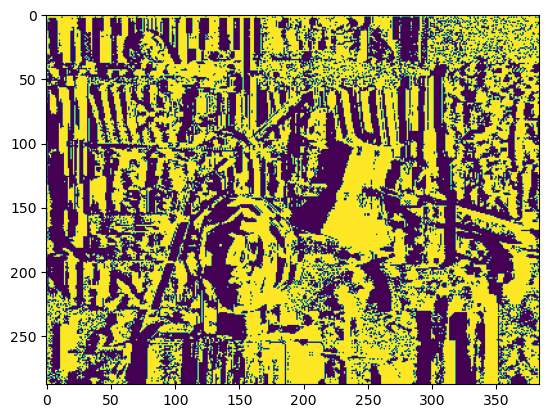

In [79]:
func(1)

<h4>GrabCut uses some random values during the initialization phase to assign each pixel to a foreground or background class. Specifically, during the initialization phase, the algorithm randomly samples some pixels from the image and assigns them to the foreground and background classes. Then, it uses these initial assignments to train a Gaussian Mixture Model (GMM) for each class, which is used to update the pixel assignments in subsequent iterations of the algorithm. The use of random initialization helps to prevent the algorithm from getting stuck in local optima and helps to ensure that it can explore different parts of the image during the optimization process.</h4>

In [99]:
def get_accuracy2(mask, gt):
    correct = np.sum(np.logical_and(mask == 255, gt == 255)) + np.sum(np.logical_and(mask == 0, gt == 0))
    total = np.prod(mask.shape)
    return correct/total

In [98]:
def get_accuracy(mask, seg_map, ground_truth):
    one = mask[seg_map == ground_truth].shape[0]
    two = ground_truth.shape[0] * ground_truth.shape[1]
    return one/two

In [86]:
def iou_coef(y_true, y_pred, smooth=1):
  y_true = np.array(y_true, dtype=np.int16)//255
  y_pred = np.array(y_pred, dtype=np.int16)
  intersection = np.sum(np.abs(y_true * y_pred))
  union = np.sum(y_true)+np.sum(y_pred)-intersection
  iou = np.mean((intersection + smooth) / (union + smooth))
  return iou

In [44]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = np.sum(y_true * y_pred)
  union = np.sum(y_true) + np.sum(y_pred)
  dice = np.mean((2 * intersection + smooth)/(union + smooth))
  return dice

In [67]:
def get_bounding_box(mask):
    contours, hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    bounding_boxes = [cv.boundingRect(contour) for contour in contours]
    return bounding_boxes

In [14]:
def get_grnd_truth(image):
    path = '/kaggle/input/section-2-grabcut/section-2-grabcut/ground_truth'
    img_name = os.path.splitext(image)[0]
    return cv.cvtColor(cv.imread(os.path.join(path, img_name+'.bmp')), cv.COLOR_BGR2GRAY)

In [13]:
def get_image(image_name):
    path = '/kaggle/input/section-2-grabcut/section-2-grabcut/images'
    return cv.cvtColor(cv.imread(os.path.join(path, image_name)), cv.COLOR_BGR2RGB)

In [42]:
def work(img, image_name, bound_box, iteration=5):
    mask = np.zeros(img.shape[:2],np.uint8)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    rect = bound_box
    cv.grabCut(img,mask,rect,bgdModel,fgdModel,iteration,cv.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img1 = img*mask2[:,:,np.newaxis]
    plt.imshow(img1),plt.colorbar(),plt.show()
    
    gt_mask = get_grnd_truth(image_name)

    # Resize the binary mask to match the size of the ground truth mask
    mask2_resized = cv.resize(mask2, (gt_mask.shape[1], gt_mask.shape[0]))

    # Calculate the evaluation metrics
    tp = np.sum((gt_mask == 255) & (mask2_resized == 1))
    tn = np.sum((gt_mask == 0) & (mask2_resized == 0))
    fp = np.sum((gt_mask == 0) & (mask2_resized == 1))
    fn = np.sum((gt_mask == 255) & (mask2_resized == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    jaccard_index = tp / (tp + fp + fn)
    f1_score = 2 * tp / (2 * tp + fp + fn)

    print("Accuracy: {:.4f}".format(accuracy))
    print("Jaccard Index: {:.4f}".format(jaccard_index))
    print("F1 Score: {:.4f}".format(f1_score))
    print()
    

<h4>The number of iterations of GMM updating and energy minimization affects the accuracy and speed of the GrabCut algorithm. Generally, increasing the number of iterations improves the segmentation accuracy but also increases the computation time. However, beyond a certain point, increasing the number of iterations may not provide much improvement in accuracy. On the other hand, reducing the number of iterations may result in a faster but less accurate segmentation. Therefore, the choice of the number of iterations depends on the trade-off between accuracy and speed for the specific application.</h4>

In [24]:
def exp1(image, image_name, bound_box):
    print('starting experiment 1')
    for it in range(2, 7):
        print('with iterations', it)
        work(image, image_name, bound_box, it)

<h4>The tightness of the initial bounding box affects the quality of the GrabCut segmentation. A tight bounding box provides more information about the foreground and background regions and helps to accurately segment the object of interest. However, if the bounding box is loose, it may result in the inclusion of background pixels inside the foreground region, leading to inaccurate segmentation. On the other hand, a very tight bounding box may result in the exclusion of some foreground pixels, leading to under-segmentation. Therefore, the choice of the bounding box depends on the specific application and the properties of the object of interest.</h4>

In [36]:
def exp2(image, image_name, bound_box):
    print('starting experiment 2')
    start_box = [bound_box[0] + 30, bound_box[1] + 30, bound_box[2] - 50, bound_box[3] - 50]
    for _ in range(4):
        print('with bound_box', start_box)
        work(image, image_name, start_box)
        start_box[0] -= 20
        if start_box[0] < 0:
            break
        start_box[1] -= 20
        if start_box[1] < 0:
            break
        start_box[2] += 50
        if start_box[0] + start_box[1] > image.shape[0]:
            break
        start_box[3] += 50
        if start_box[1] + start_box[3] > image.shape[1]:
            break
    
    print('with entire image as bound box')
    work(image, image_name, (0, 0, image.shape[0], image.shape[1]), 10)

<h4>The color space or representation of pixels used for GrabCut segmentation affects the accuracy and robustness of the segmentation. Different color spaces capture different aspects of the color distribution, and some may be more suitable for specific objects or backgrounds. For example, the HSV color space separates color information from intensity, which may be useful for objects with varying illumination. Similarly, other color spaces such as LAB or YCbCr capture color information in different ways and may provide better segmentation results for certain objects or backgrounds. Therefore, the choice of the color space or representation of pixels depends on the specific application and the properties of the objects and backgrounds in the images. Evaluating the results using the evaluation metrics can help to compare the performance of different color spaces or pixel representations and choose the most suitable one for the application.</h4>

In [44]:
def exp3(image, image_name, bound_box):
    print('starting experiment 3')
#     #gray color space
#     print('Now doing for Gray scale image')
#     img_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
#     plt.imshow(img_gray)
#     work(img_gray, image_name, bound_box)
    #hsv color space
    print('Now doing for HSV color image')
    img_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    plt.imshow(img_hsv)
    work(img_hsv, image_name, bound_box)
    #lab color space
    print('Now doing for lab color image')
    img_lab = cv.cvtColor(image, cv.COLOR_RGB2LAB)
    plt.imshow(img_lab)
    work(img_lab, image_name, bound_box)

In [50]:
def func(image_name, bound_box):
    image = get_image(image_name)
    print('Now starting for image', image_name)
    plt.imshow(image)
    plt.show()
    exp1(image, image_name, bound_box)
    exp2(image, image_name, bound_box)
    exp3(image, image_name, bound_box)

Now starting for image ceramic.jpg


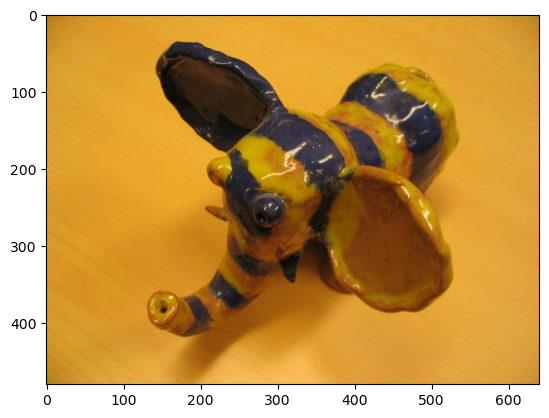

starting experiment 1
with iterations 2


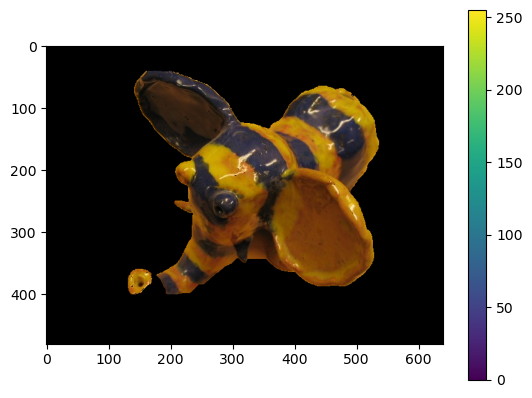

Accuracy: 0.9865
Jaccard Index: 0.9565
F1 Score: 0.9778

with iterations 3


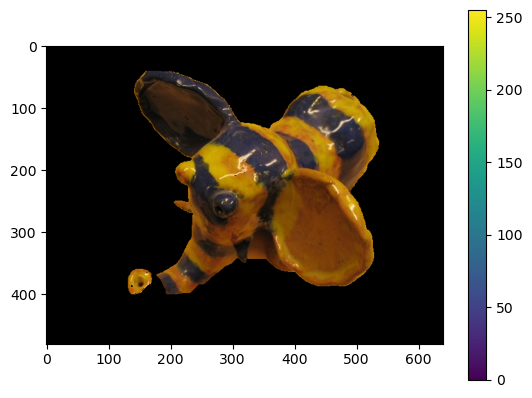

Accuracy: 0.9865
Jaccard Index: 0.9566
F1 Score: 0.9778

with iterations 4


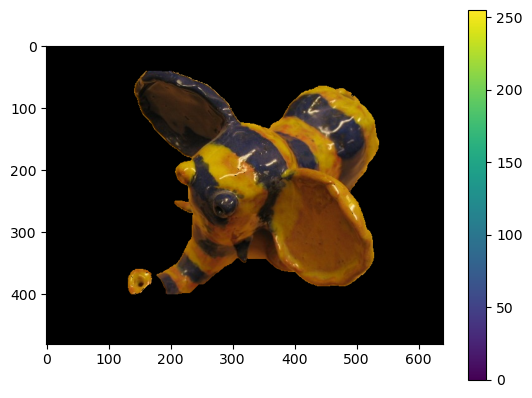

Accuracy: 0.9865
Jaccard Index: 0.9566
F1 Score: 0.9778

with iterations 5


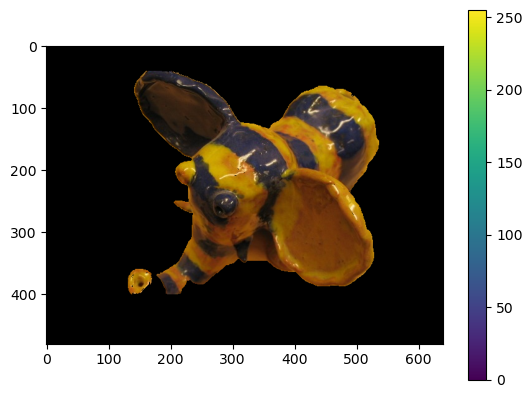

Accuracy: 0.9851
Jaccard Index: 0.9522
F1 Score: 0.9755

with iterations 6


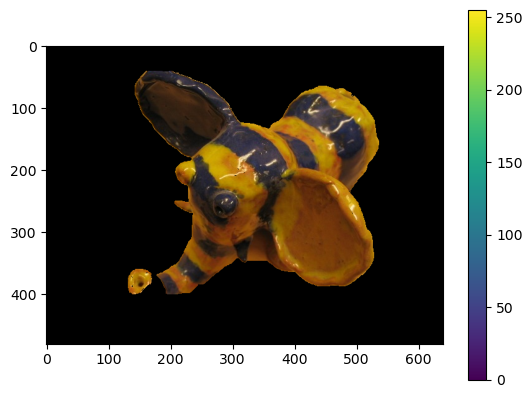

Accuracy: 0.9862
Jaccard Index: 0.9556
F1 Score: 0.9773

starting experiment 2
with bound_box [70, 70, 449, 310]


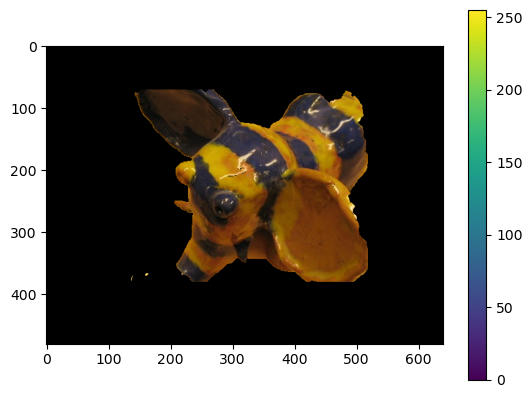

Accuracy: 0.9571
Jaccard Index: 0.8615
F1 Score: 0.9256

with bound_box [50, 50, 499, 360]


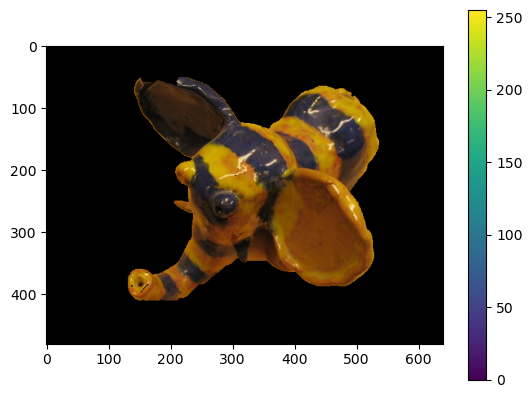

Accuracy: 0.9880
Jaccard Index: 0.9616
F1 Score: 0.9804

with bound_box [30, 30, 549, 410]


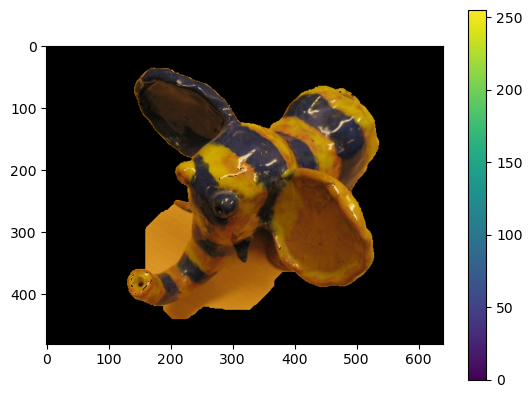

Accuracy: 0.9411
Jaccard Index: 0.8377
F1 Score: 0.9117

with bound_box [10, 10, 599, 460]


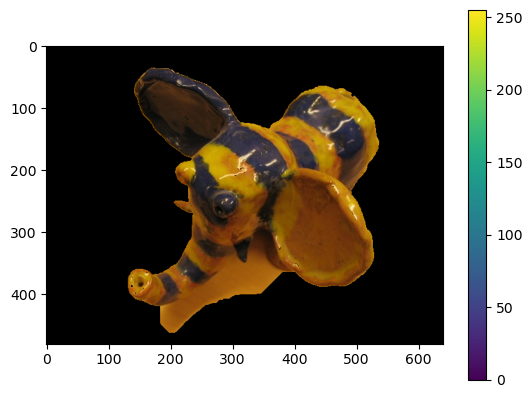

Accuracy: 0.9643
Jaccard Index: 0.8951
F1 Score: 0.9446

with entire image as bound box


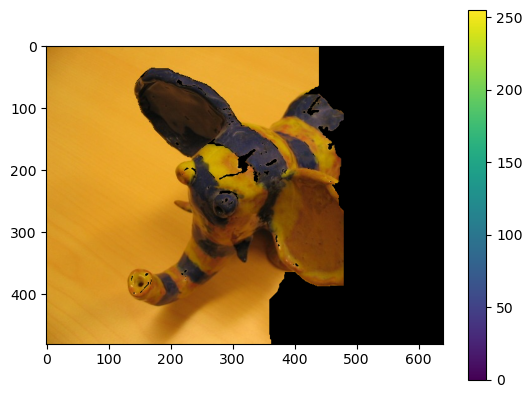

Accuracy: 0.5135
Jaccard Index: 0.3414
F1 Score: 0.5090

starting experiment 3
Now doing for HSV color image


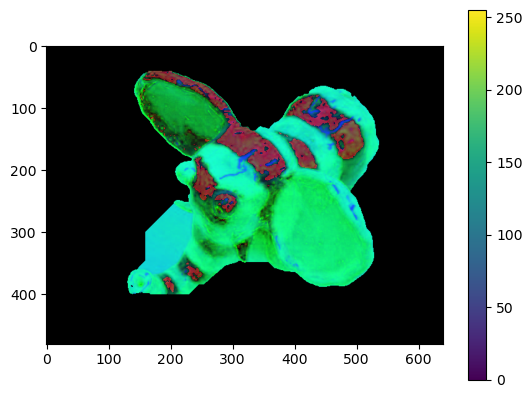

Accuracy: 0.9679
Jaccard Index: 0.9032
F1 Score: 0.9491

Now doing for lab color image


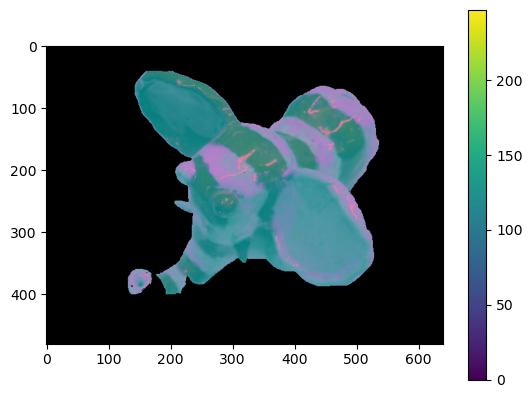

Accuracy: 0.9857
Jaccard Index: 0.9540
F1 Score: 0.9765



In [51]:
func('ceramic.jpg', np.array((40,40,499,360)))

Now starting for image book.jpg


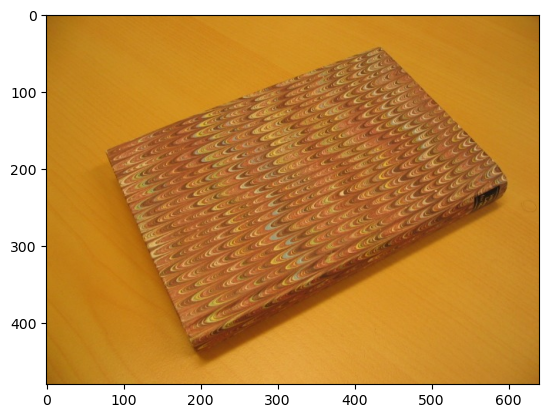

starting experiment 1
with iterations 2


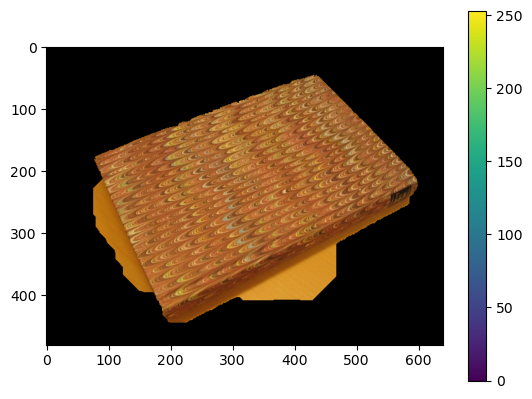

Accuracy: 0.9361
Jaccard Index: 0.8523
F1 Score: 0.9203

with iterations 3


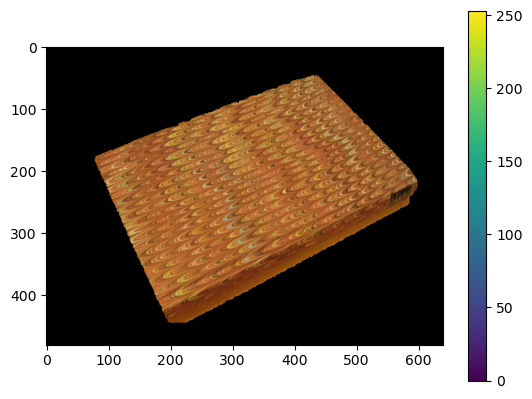

Accuracy: 0.9783
Jaccard Index: 0.9444
F1 Score: 0.9714

with iterations 4


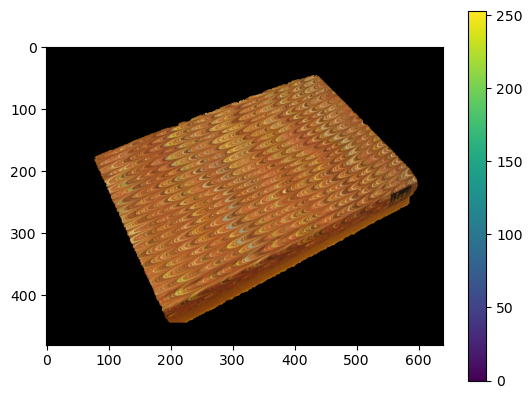

Accuracy: 0.9784
Jaccard Index: 0.9447
F1 Score: 0.9716

with iterations 5


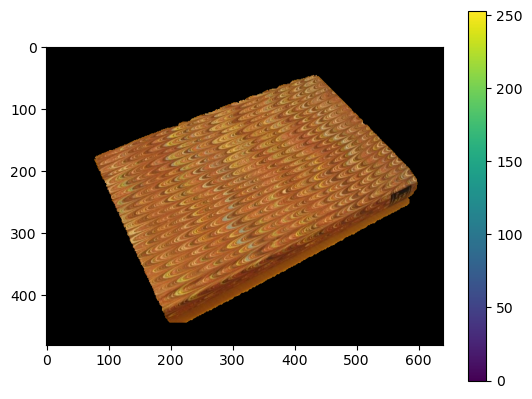

Accuracy: 0.9783
Jaccard Index: 0.9444
F1 Score: 0.9714

with iterations 6


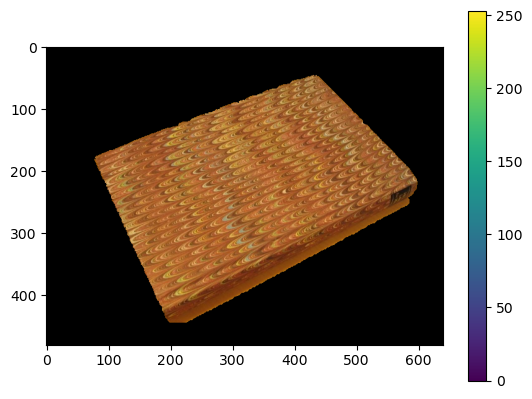

Accuracy: 0.9783
Jaccard Index: 0.9444
F1 Score: 0.9714

starting experiment 2
with bound_box [86, 74, 500, 350]


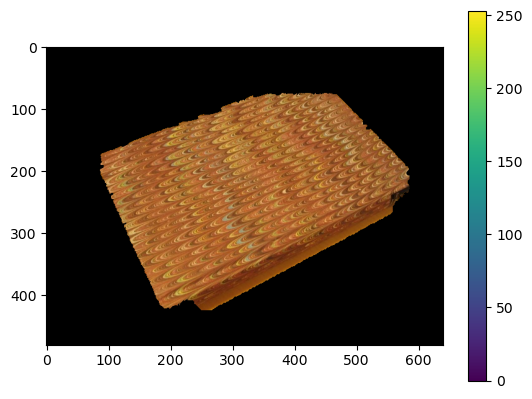

Accuracy: 0.9695
Jaccard Index: 0.9211
F1 Score: 0.9589

with bound_box [66, 54, 550, 400]


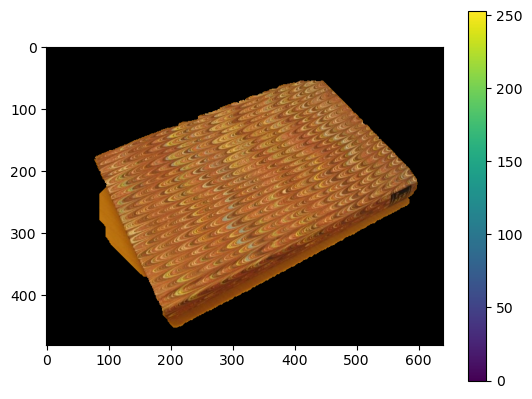

Accuracy: 0.9658
Jaccard Index: 0.9149
F1 Score: 0.9556

with bound_box [46, 34, 600, 450]


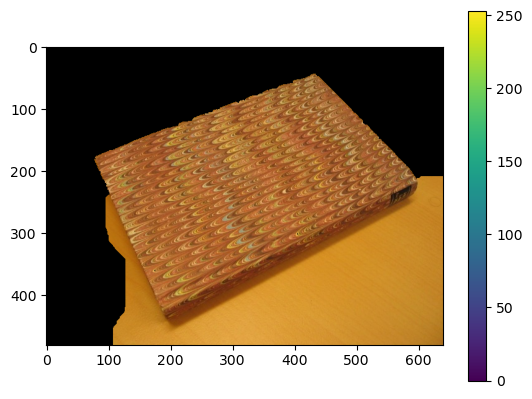

Accuracy: 0.7410
Jaccard Index: 0.5876
F1 Score: 0.7403

with bound_box [26, 14, 650, 500]


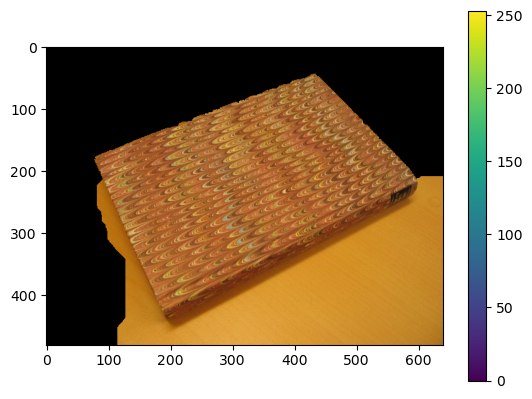

Accuracy: 0.7396
Jaccard Index: 0.5863
F1 Score: 0.7392

with entire image as bound box


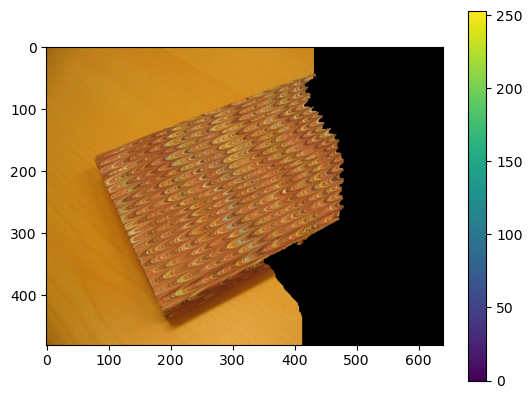

Accuracy: 0.5643
Jaccard Index: 0.4108
F1 Score: 0.5823

starting experiment 3
Now doing for HSV color image


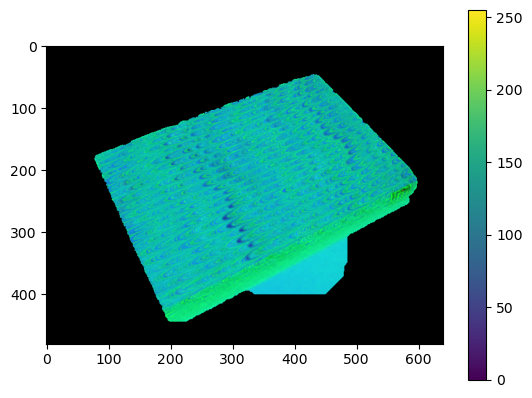

Accuracy: 0.9542
Jaccard Index: 0.8895
F1 Score: 0.9415

Now doing for lab color image


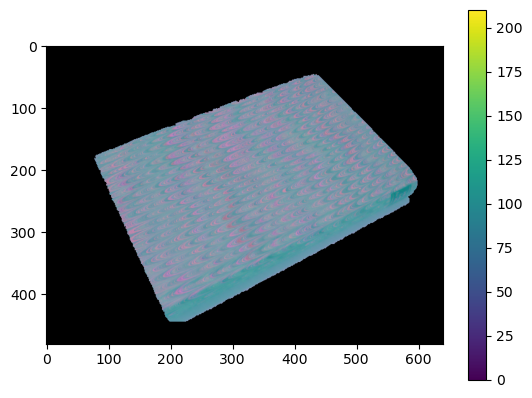

Accuracy: 0.9785
Jaccard Index: 0.9450
F1 Score: 0.9717



In [52]:
func('book.jpg', np.array((56, 44, 550, 400)))

Now starting for image llama.jpg


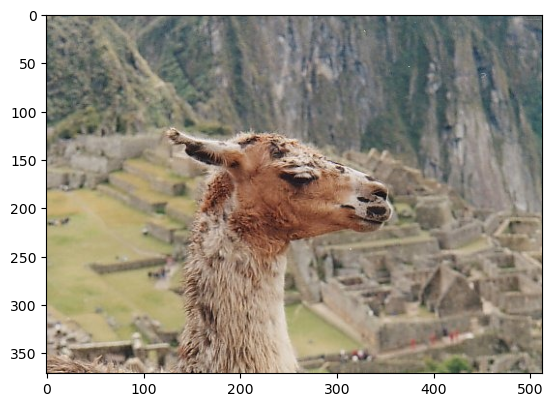

starting experiment 1
with iterations 2


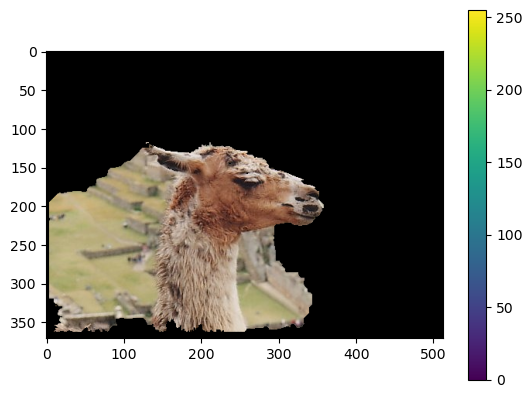

Accuracy: 0.7954
Jaccard Index: 0.4466
F1 Score: 0.6174

with iterations 3


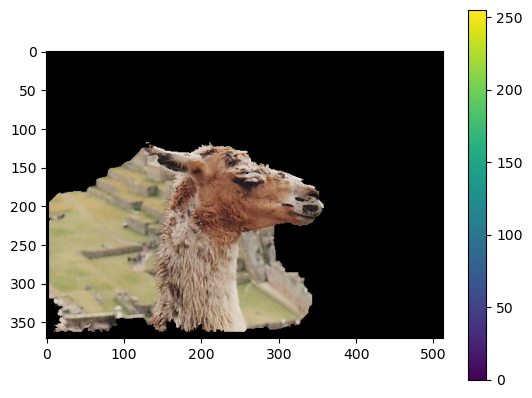

Accuracy: 0.7950
Jaccard Index: 0.4448
F1 Score: 0.6157

with iterations 4


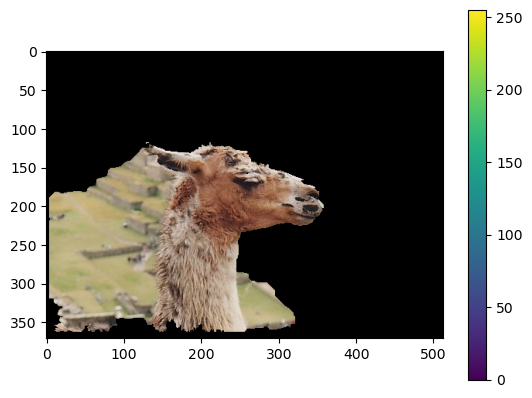

Accuracy: 0.8221
Jaccard Index: 0.4792
F1 Score: 0.6480

with iterations 5


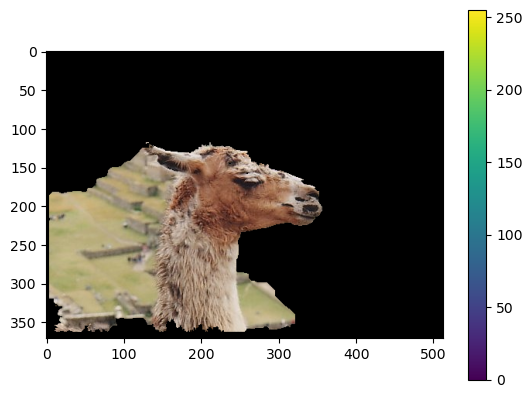

Accuracy: 0.8216
Jaccard Index: 0.4779
F1 Score: 0.6467

with iterations 6


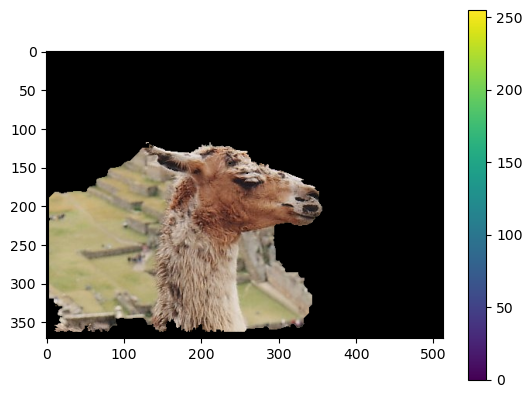

Accuracy: 0.7942
Jaccard Index: 0.4436
F1 Score: 0.6146

starting experiment 2
with bound_box [34, 133, 310, 210]


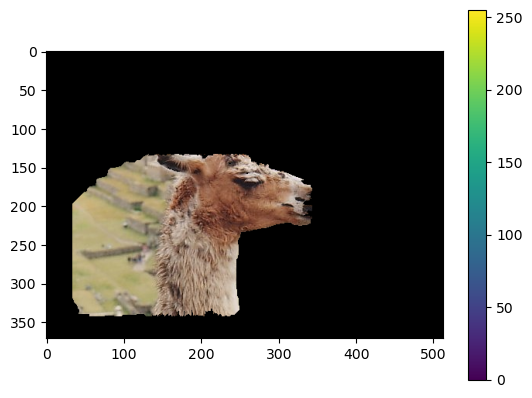

Accuracy: 0.8554
Jaccard Index: 0.4979
F1 Score: 0.6648

with bound_box [14, 113, 360, 260]


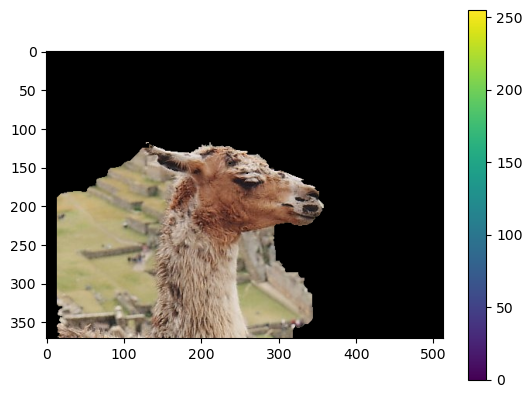

Accuracy: 0.7954
Jaccard Index: 0.4578
F1 Score: 0.6280

with entire image as bound box


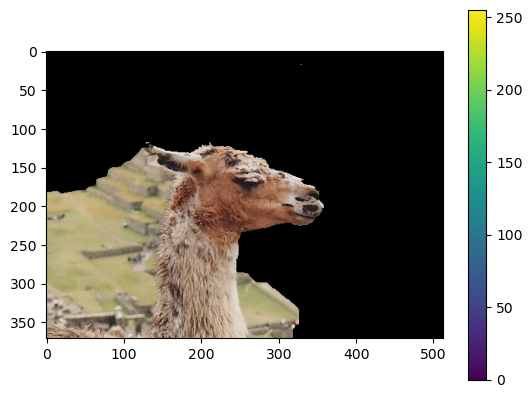

Accuracy: 0.8071
Jaccard Index: 0.4716
F1 Score: 0.6410

starting experiment 3
Now doing for HSV color image


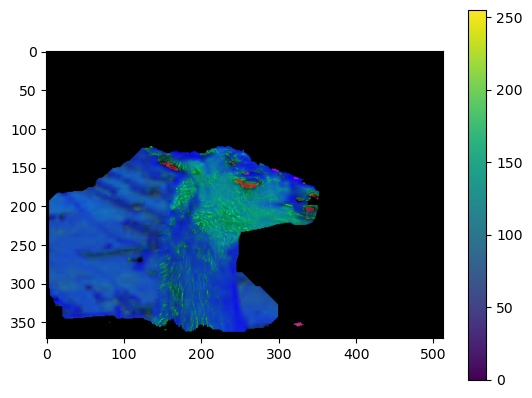

Accuracy: 0.8314
Jaccard Index: 0.4875
F1 Score: 0.6554

Now doing for lab color image


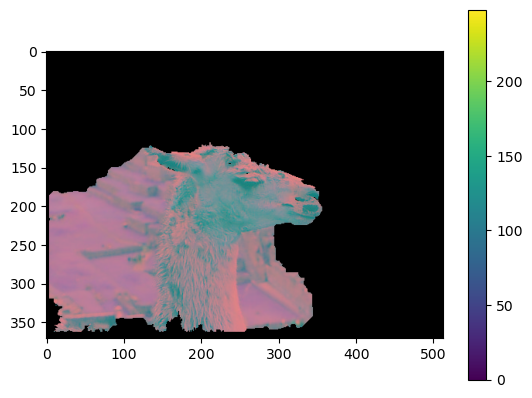

Accuracy: 0.7918
Jaccard Index: 0.4385
F1 Score: 0.6097



In [53]:
func('llama.jpg', np.array((4, 103, 360, 260)))

Now starting for image flower.jpg


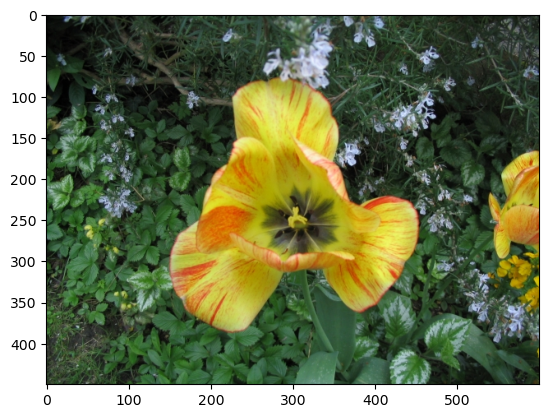

starting experiment 1
with iterations 2


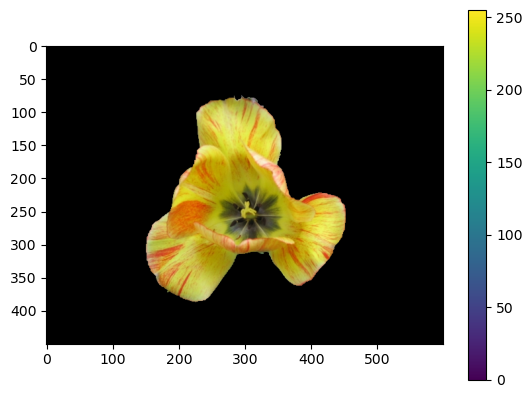

Accuracy: 0.9965
Jaccard Index: 0.9822
F1 Score: 0.9910

with iterations 3


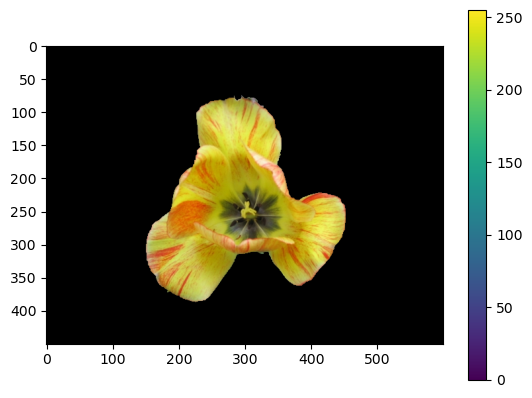

Accuracy: 0.9966
Jaccard Index: 0.9826
F1 Score: 0.9912

with iterations 4


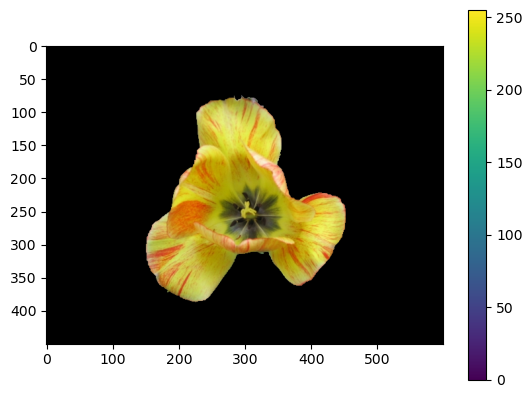

Accuracy: 0.9965
Jaccard Index: 0.9824
F1 Score: 0.9911

with iterations 5


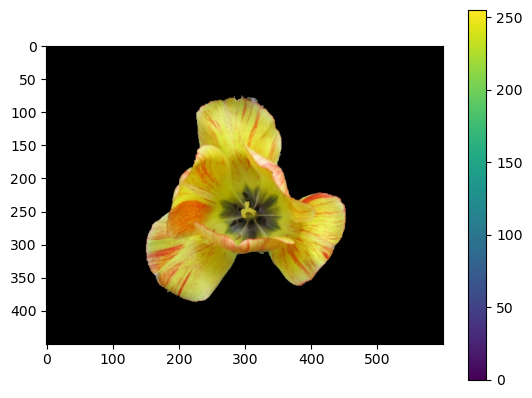

Accuracy: 0.9966
Jaccard Index: 0.9826
F1 Score: 0.9912

with iterations 6


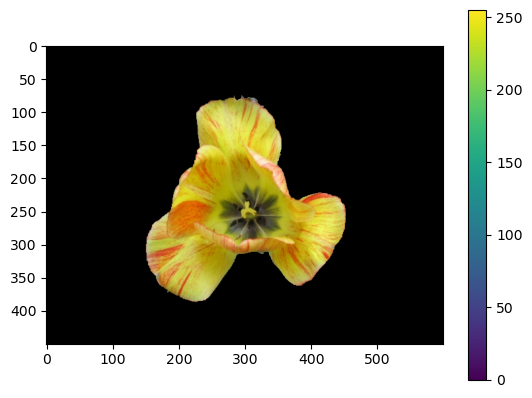

Accuracy: 0.9965
Jaccard Index: 0.9824
F1 Score: 0.9911

starting experiment 2
with bound_box [148, 98, 290, 280]


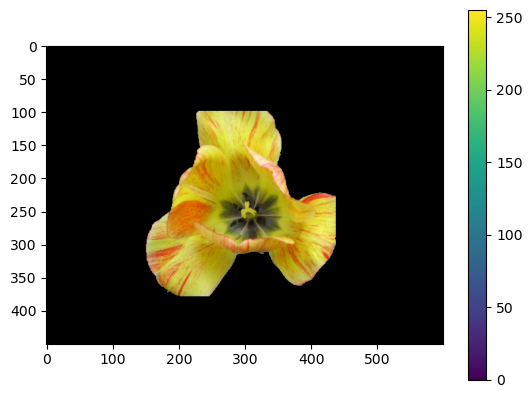

Accuracy: 0.9888
Jaccard Index: 0.9427
F1 Score: 0.9705

with bound_box [128, 78, 340, 330]


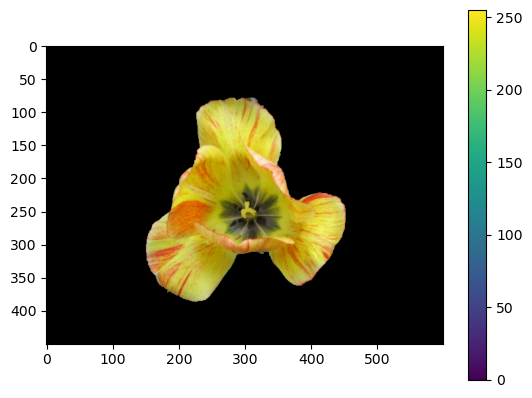

Accuracy: 0.9966
Jaccard Index: 0.9828
F1 Score: 0.9913

with bound_box [108, 58, 390, 380]


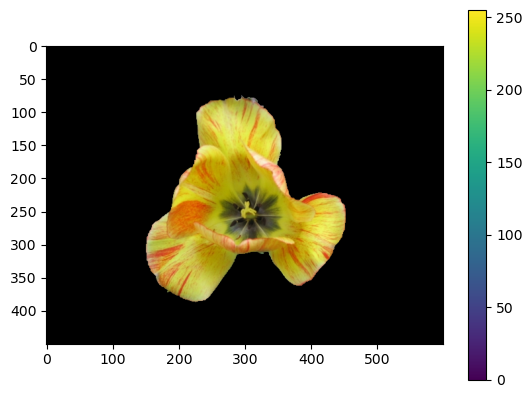

Accuracy: 0.9965
Jaccard Index: 0.9823
F1 Score: 0.9911

with bound_box [88, 38, 440, 430]


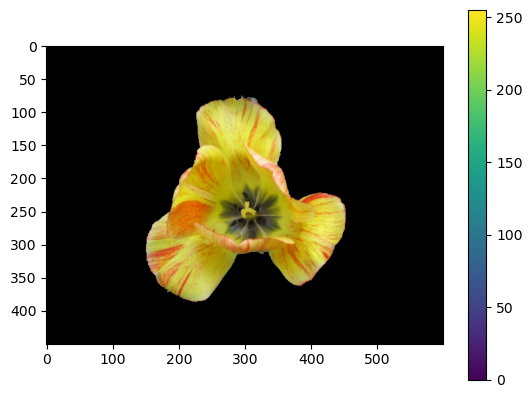

Accuracy: 0.9966
Jaccard Index: 0.9828
F1 Score: 0.9913

with entire image as bound box


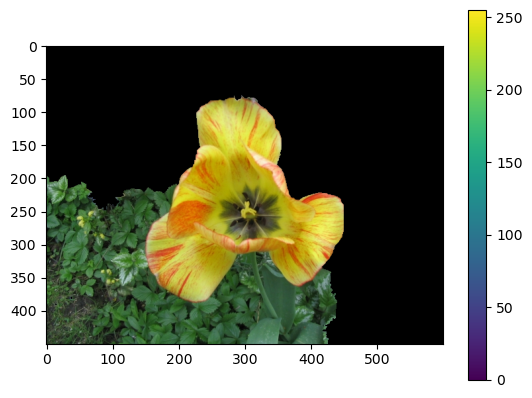

Accuracy: 0.7557
Jaccard Index: 0.4419
F1 Score: 0.6129

starting experiment 3
Now doing for HSV color image


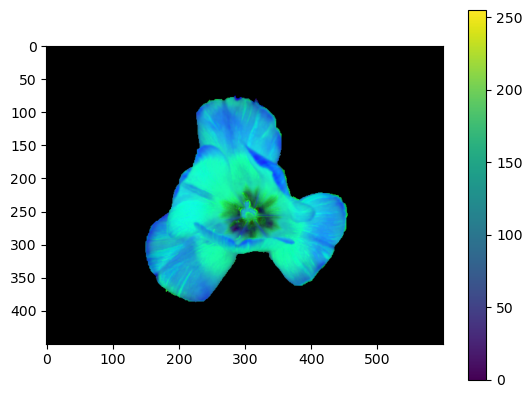

Accuracy: 0.9944
Jaccard Index: 0.9719
F1 Score: 0.9858

Now doing for lab color image


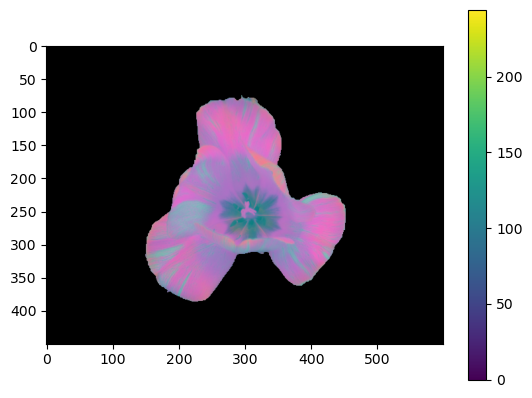

Accuracy: 0.9965
Jaccard Index: 0.9820
F1 Score: 0.9909



In [54]:
func('flower.jpg', np.array((118, 68, 340, 330)))

Now starting for image tennis.jpg


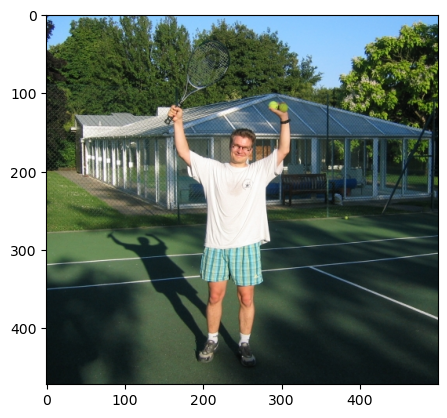

starting experiment 1
with iterations 2


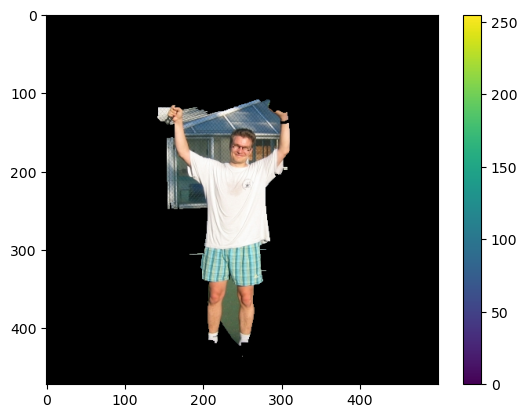

Accuracy: 0.9449
Jaccard Index: 0.5836
F1 Score: 0.7371

with iterations 3


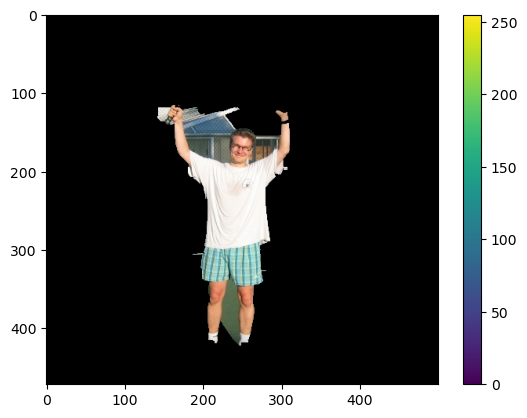

Accuracy: 0.9661
Jaccard Index: 0.6939
F1 Score: 0.8193

with iterations 4


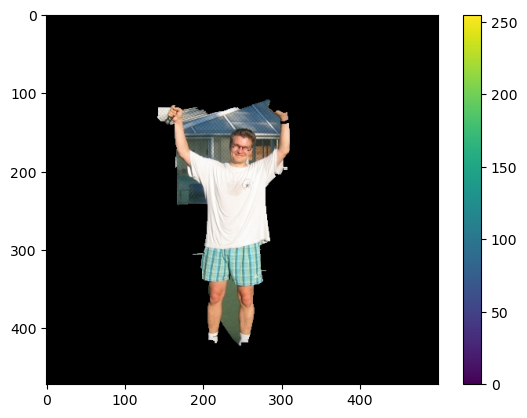

Accuracy: 0.9511
Jaccard Index: 0.6118
F1 Score: 0.7591

with iterations 5


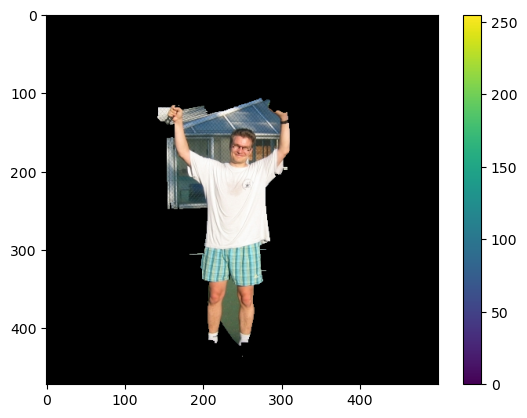

Accuracy: 0.9447
Jaccard Index: 0.5832
F1 Score: 0.7367

with iterations 6


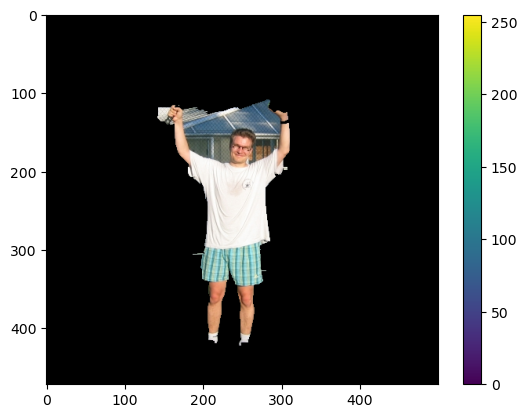

Accuracy: 0.9632
Jaccard Index: 0.6759
F1 Score: 0.8066

starting experiment 2
with bound_box [171, 137, 120, 340]


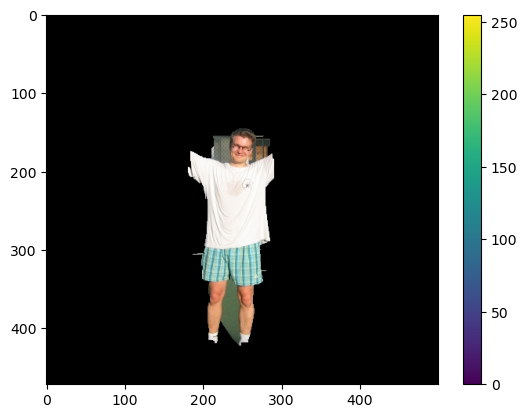

Accuracy: 0.9732
Jaccard Index: 0.7206
F1 Score: 0.8376

with entire image as bound box


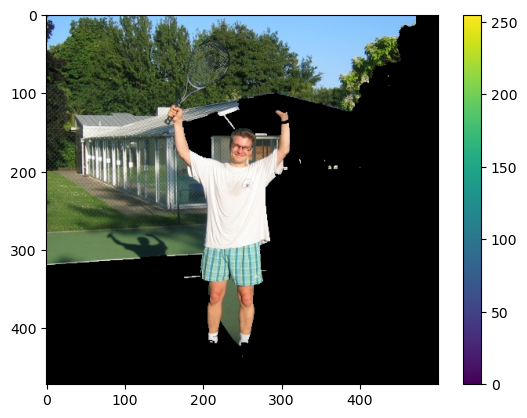

Accuracy: 0.6088
Jaccard Index: 0.1647
F1 Score: 0.2829

starting experiment 3
Now doing for HSV color image


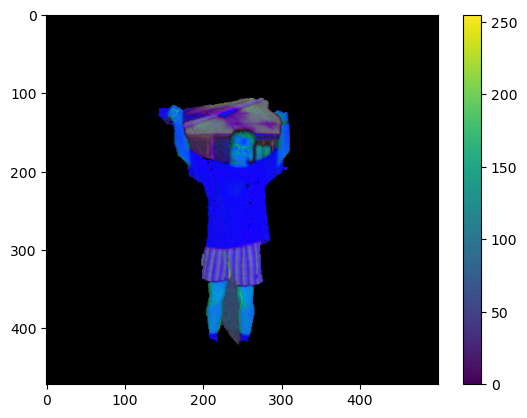

Accuracy: 0.9534
Jaccard Index: 0.6214
F1 Score: 0.7665

Now doing for lab color image


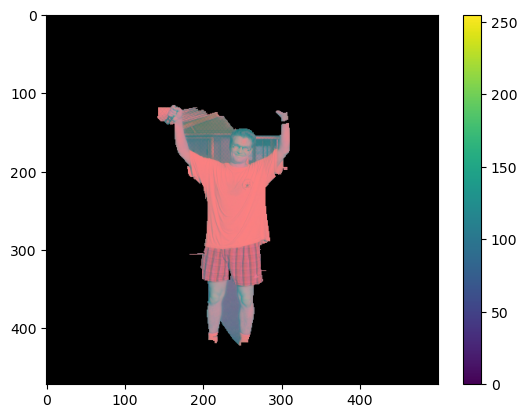

Accuracy: 0.9666
Jaccard Index: 0.6977
F1 Score: 0.8219



In [58]:
func('tennis.jpg', np.array([141, 107, 170, 390]))